In [49]:
import csv
#Install AIF360
!pip install 'aif360[all]'

random_state = 1234567

In [50]:
%matplotlib inline
from matplotlib import pyplot as plt
from os import getenv
import os.path as path
import numpy as np
import pandas as pd

import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
tf.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder

from aif360.sklearn.preprocessing import Reweighing, ReweighingMeta
from aif360.sklearn.inprocessing import AdversarialDebiasing
from aif360.sklearn.postprocessing import CalibratedEqualizedOdds, PostProcessingMeta
from aif360.sklearn.datasets import fetch_adult
from aif360.sklearn.metrics import disparate_impact_ratio, average_odds_error, generalized_fpr
from aif360.sklearn.metrics import generalized_fnr, difference

# Adult dataset

## Loading data

Datasets are formatted as separate `X` (# samples x # features) and `y` (# samples x # labels) DataFrames. The index of each DataFrame contains protected attribute values per sample. Datasets may also load a `sample_weight` object to be used with certain algorithms/metrics. All of this makes it so that aif360 is compatible with scikit-learn objects.

For example, we can easily load the Adult dataset from UCI with the following line:

In [51]:
X, y, _ = fetch_adult()
X.head(10)

age         workclass     education  education-num  \
race      sex                                                          
Non-white Male     25           Private          11th              7   
White     Male     38           Private       HS-grad              9   
          Male     28         Local-gov    Assoc-acdm             12   
Non-white Male     44           Private  Some-college             10   
White     Male     34           Private          10th              6   
          Male     63  Self-emp-not-inc   Prof-school             15   
          Female   24           Private  Some-college             10   
          Male     55           Private       7th-8th              4   
          Male     65           Private       HS-grad              9   
          Male     36       Federal-gov     Bachelors             13   

                      marital-status         occupation   relationship   race  \
race      sex                                                                   
Non-white Male         Never-married  Machine-op-inspct      Own-child  Black   
White     Male    Married-civ-spouse    Farming-fishing        Husband  White   
          Male    Married-civ-spouse    Protective-serv        Husband  White   
Non-white Male    Married-civ-spouse  Machine-op-inspct        Husband  Black   
White     Male         Never-married      Other-service  Not-in-family  White   
          Male    Married-civ-spouse     Prof-specialty        Husband  White   
          Female       Never-married      Other-service      Unmarried  White   
          Male    Married-civ-spouse       Craft-repair        Husband  White   
          Male    Married-civ-spouse  Machine-op-inspct        Husband  White   
          Male    Married-civ-spouse       Adm-clerical        Husband  White   

                     sex  capital-gain  capital-loss  hours-per-week  \
race      sex                                                          
Non-white Male      Male             0             0              40   
White     Male      Male             0             0              50   
          Male      Male             0             0              40   
Non-white Male      Male          7688             0              40   
White     Male      Male             0             0              30   
          Male      Male          3103             0              32   
          Female  Female             0             0              40   
          Male      Male             0             0              10   
          Male      Male          6418             0              40   
          Male      Male             0             0              40   

                 native-country  
race      sex                    
Non-white Male    United-States  
White     Male    United-States  
          Male    United-States  
Non-white Male    United-States  
White     Male    United-States  
          Male    United-States  
          Female  United-States  
          Male    United-States  
          Male    United-States  
          Male    United-States

We can then map the protected attributes to integers,

In [53]:
X.index = pd.MultiIndex.from_arrays(X.index.codes, names=X.index.names)
y.index = pd.MultiIndex.from_arrays(y.index.codes, names=y.index.names)

and the target classes to 0/1,

In [54]:
y = pd.Series(y.factorize(sort=True)[0], index=y.index, name=y.name)

split the dataset,

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=random_state)

and finally, one-hot encode the categorical features:

In [56]:
ohe = make_column_transformer(
        (OneHotEncoder(sparse_output=False), X_train.dtypes == 'category'),
        remainder='passthrough', verbose_feature_names_out=False)
X_train  = pd.DataFrame(ohe.fit_transform(X_train), columns=ohe.get_feature_names_out(), index=X_train.index)
X_test = pd.DataFrame(ohe.transform(X_test), columns=ohe.get_feature_names_out(), index=X_test.index)

X_train.head(10)

workclass_Federal-gov  workclass_Local-gov  workclass_Private  \
race sex                                                                  
1    1                      0.0                  0.0                0.0   
     0                      0.0                  0.0                0.0   
     1                      0.0                  0.0                1.0   
     1                      0.0                  0.0                1.0   
     1                      0.0                  0.0                1.0   
     1                      0.0                  0.0                1.0   
     1                      0.0                  0.0                1.0   
     1                      0.0                  0.0                0.0   
     0                      0.0                  0.0                1.0   
     1                      0.0                  0.0                0.0   

          workclass_Self-emp-inc  workclass_Self-emp-not-inc  \
race sex                                                       
1    1                       0.0                         1.0   
     0                       0.0                         1.0   
     1                       0.0                         0.0   
     1                       0.0                         0.0   
     1                       0.0                         0.0   
     1                       0.0                         0.0   
     1                       0.0                         0.0   
     1                       0.0                         1.0   
     0                       0.0                         0.0   
     1                       0.0                         1.0   

          workclass_State-gov  workclass_Without-pay  education_10th  \
race sex                                                               
1    1                    0.0                    0.0             0.0   
     0                    0.0                    0.0             0.0   
     1                    0.0                    0.0             0.0   
     1                    0.0                    0.0             0.0   
     1                    0.0                    0.0             1.0   
     1                    0.0                    0.0             0.0   
     1                    0.0                    0.0             0.0   
     1                    0.0                    0.0             0.0   
     0                    0.0                    0.0             0.0   
     1                    0.0                    0.0             1.0   

          education_11th  education_12th  ...  native-country_Thailand  \
race sex                                  ...                            
1    1               0.0             0.0  ...                      0.0   
     0               0.0             0.0  ...                      0.0   
     1               0.0             0.0  ...                      0.0   
     1               0.0             0.0  ...                      0.0   
     1               0.0             0.0  ...                      0.0   
     1               1.0             0.0  ...                      0.0   
     1               0.0             0.0  ...                      0.0   
     1               0.0             0.0  ...                      0.0   
     0               0.0             0.0  ...                      0.0   
     1               0.0             0.0  ...                      0.0   

          native-country_Trinadad&Tobago  native-country_United-States  \
race sex                                                                 
1    1                               0.0                           1.0   
     0                               0.0                           0.0   
     1                               0.0                           1.0   
     1                               0.0                           0.0   
     1                               0.0                           1.0   
     1                               0.0                           1

Note: the column names are lost in this transformation. The same encoding can be done with Pandas, but this cannot be combined with other preprocessing in a Pipeline.

In [57]:
pd.get_dummies(X).head(10)

age  education-num  capital-gain  capital-loss  hours-per-week  \
race sex                                                                   
0    1     25              7             0             0              40   
1    1     38              9             0             0              50   
     1     28             12             0             0              40   
0    1     44             10          7688             0              40   
1    1     34              6             0             0              30   
     1     63             15          3103             0              32   
     0     24             10             0             0              40   
     1     55              4             0             0              10   
     1     65              9          6418             0              40   
     1     36             13             0             0              40   

          workclass_Federal-gov  workclass_Local-gov  workclass_Private  \
race sex                                                                  
0    1                    False                False               True   
1    1                    False                False               True   
     1                    False                 True              False   
0    1                    False                False               True   
1    1                    False                False               True   
     1                    False                False              False   
     0                    False                False               True   
     1                    False                False               True   
     1                    False                False               True   
     1                     True                False              False   

          workclass_Self-emp-inc  workclass_Self-emp-not-inc  ...  \
race sex                                                      ...   
0    1                     False                       False  ...   
1    1                     False                       False  ...   
     1                     False                       False  ...   
0    1                     False                       False  ...   
1    1                     False                       False  ...   
     1                     False                        True  ...   
     0                     False                       False  ...   
     1                     False                       False  ...   
     1                     False                       False  ...   
     1                     False                       False  ...   

          native-country_Portugal  native-country_Puerto-Rico  \
race sex                                                        
0    1                      False                       False   
1    1                      False                       False   
     1                      False                       False   
0    1                      False                       False   
1    1                      False                       False   
     1                      False                       False   
     0                      False                       False   
     1                      False                       False   
     1                      False                       False   
     1                      False                       False   

          native-country_Scotland  native-country_South  \
race sex                                                  
0    1                      False                 False   
1    1                      False                 False   
     1                      False                 False   
0    1                      False                 False   
1    1                      False                 False   
     1                      False                 False   
     0                      False                 False   
     1                      False                 False

The protected attribute information is also replicated in the labels:

In [58]:
y_train.head(10)

race  sex
1     1      0
      0      1
      1      1
      1      0
      1      0
      1      0
      1      0
      1      0
      0      0
      1      0
Name: annual-income, dtype: int64

## Running metrics

With the data in this format, we can easily train a scikit-learn model and get predictions for the test data:

In [59]:
y_pred = LogisticRegression(solver='liblinear').fit(X_train, y_train).predict(X_test)
accuracy_score(y_test, y_pred)

0.8454337731259675

Now, we can analyze our predictions and quickly calculate the disparate impact for females vs. males:

In [60]:
disparate_impact_ratio(y_test, y_pred, prot_attr='sex')

0.2687836637388684

We can also calculate the disparate impact for a different attribute, race, comparing whites to non-whites: 

In [61]:
disparate_impact_ratio(y_test, y_pred, prot_attr='race')

0.5457741065389056

And similarly, we can assess how close the predictions are to equality of odds.

`average_odds_error()` computes the (unweighted) average of the absolute values of the true positive rate (TPR) difference and false positive rate (FPR) difference, i.e.:

$$ \tfrac{1}{2}\left(|FPR_{D = \text{unprivileged}} - FPR_{D = \text{privileged}}| + |TPR_{D = \text{unprivileged}} - TPR_{D = \text{privileged}}|\right) $$

In [62]:
average_odds_error(y_test, y_pred, priv_group=(1, 1))

0.09884873540555517

In that case, we chose to look at the intersection of all protected attributes (race and sex) and designate a single combination (white males) as privileged.

If we wish to do something more complex, we can pass a custom array of protected attributes, like so (note: this choice of protected groups is just for demonstration):

In [63]:
race = y_test.index.get_level_values('race').to_numpy()
sex = y_test.index.get_level_values('sex').to_numpy()
prot_attr = np.where(race ^ sex, 0, 1)
disparate_impact_ratio(y_test, y_pred, prot_attr=prot_attr)

0.3842555696519781

## Debiasing algorithms

`ReweighingMeta` is a workaround until changing sample weights can be handled properly in `Pipeline`/`GridSearchCV`

In [64]:
rew = ReweighingMeta(estimator=LogisticRegression(solver='liblinear'),
                     reweigher=Reweighing('sex'))

params = {'estimator__C': [1, 10]}

clf = GridSearchCV(rew, params, scoring='accuracy', cv=5)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
print(clf.best_params_)

0.8402741947372301
{'estimator__C': 1}


In [65]:
disparate_impact_ratio(y_test, clf.predict(X_test), prot_attr='sex')

0.5869536164535801

Rather than trying to weight accuracy and fairness, we can try a fair in-processing algorithm:

In [66]:
adv_deb = AdversarialDebiasing(prot_attr='sex', random_state=random_state)
adv_deb.fit(X_train, y_train)
adv_deb.score(X_test, y_test)

0.840569027788015

In [67]:
average_odds_error(y_test, adv_deb.predict(X_test), prot_attr='sex')

0.0674177070960344

Note that `AdversarialDebiasing` creates a TensorFlow session which we should close when we're finished to free up resources:

In [68]:
adv_deb.sess_.close()

Finally, let's try a post-processor, `CalibratedEqualizedOdds`.

Since the post-processor needs to be trained on data unseen by the original estimator, we will use the `PostProcessingMeta` class which splits the data and trains the estimator and post-processor with their own split.

In [69]:
cal_eq_odds = CalibratedEqualizedOdds('sex', cost_constraint='fnr', random_state=random_state)
log_reg = LogisticRegression(solver='liblinear')
postproc = PostProcessingMeta(estimator=log_reg, postprocessor=cal_eq_odds, random_state=random_state)

postproc.fit(X_train, y_train)
accuracy_score(y_test, postproc.predict(X_test))

0.8200044224957618

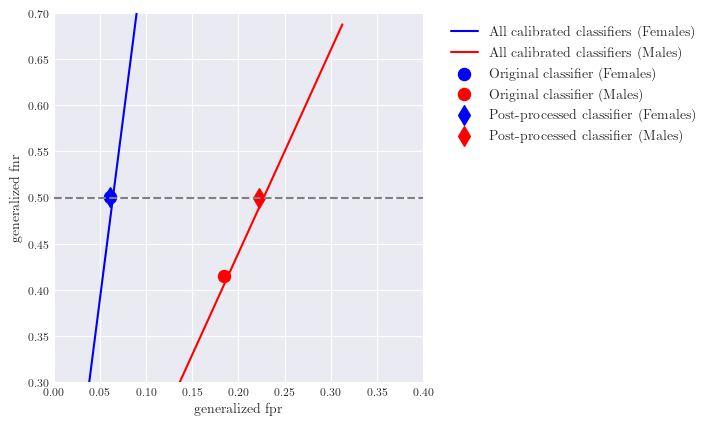

In [70]:
y_pred = postproc.predict_proba(X_test)[:, 1]
y_lr = postproc.estimator_.predict_proba(X_test)[:, 1]
br = postproc.postprocessor_.base_rates_
i = X_test.index.get_level_values('sex') == 1

plt.style.use('seaborn-v0_8-darkgrid')
if getenv('TEXLIVE_HOME') is not None:
    plt.style.use('tex')
    plt.rcParams['legend.fontsize'] = 10

plt.plot([0, br[0]], [0, 1-br[0]], '-b', label='All calibrated classifiers (Females)')
plt.plot([0, br[1]], [0, 1-br[1]], '-r', label='All calibrated classifiers (Males)')

plt.scatter(generalized_fpr(y_test[~i], y_lr[~i]),
            generalized_fnr(y_test[~i], y_lr[~i]),
            300, c='blue', marker='.', label='Original classifier (Females)')
plt.scatter(generalized_fpr(y_test[i], y_lr[i]),
            generalized_fnr(y_test[i], y_lr[i]),
            300, c='red', marker='.', label='Original classifier (Males)')

plt.scatter(generalized_fpr(y_test[~i], y_pred[~i]),
            generalized_fnr(y_test[~i], y_pred[~i]),
            100, c='blue', marker='d', label='Post-processed classifier (Females)')
plt.scatter(generalized_fpr(y_test[i], y_pred[i]),
            generalized_fnr(y_test[i], y_pred[i]),
            100, c='red', marker='d', label='Post-processed classifier (Males)')

plt.plot([0, 1], [generalized_fnr(y_test, y_pred)]*2, '--', c='0.5')

plt.axis('square')
plt.xlim([0.0, 0.4])
plt.ylim([0.3, 0.7])
plt.xlabel('generalized fpr')
plt.ylabel('generalized fnr')
plt.legend(bbox_to_anchor=(1.04,1), loc='upper left');

We can see the generalized false negative rate is approximately equalized and the classifiers remain close to the calibration lines.

We can quanitify the discrepancy between protected groups using the `difference` operator:

In [71]:
difference(generalized_fnr, y_test, y_pred, prot_attr='sex')

0.0006948514904496772

# Bank marketing dataset

In [72]:
bank_names = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']


bank_dtypes = {
    'age': 'int64',
    'job': 'category',
    'marital': 'category',
    'education': 'category',
    'default': 'category',
    'balance': 'int64',
    'housing': 'category',
    'loan': 'category',
    'contact': 'category',
    'day': 'int64',
    'month': 'category',
    'duration': 'int64',
    'campaign': 'int64',
    'pdays': 'int64',
    'previous': 'int64',
    'poutcome': 'category',
    'y': 'category'
}

bank_data = pd.read_csv(path.join(path.pardir, 'data', 'bank-marketing', 'bank.csv'), index_col=None, delimiter=';',   dtype=bank_dtypes, header=0, na_values='unknown', names=bank_names, skipinitialspace=True)
bank_data.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,NaN,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,NaN,3,jun,199,4,-1,0,NaN,no
4,59,blue-collar,married,secondary,no,0,yes,no,NaN,5,may,226,1,-1,0,NaN,no
5,35,management,single,tertiary,no,747,no,no,cellular,23,feb,141,2,176,3,failure,no
6,36,self-employed,married,tertiary,no,307,yes,no,cellular,14,may,341,1,330,2,other,no
7,39,technician,married,secondary,no,147,yes,no,cellular,6,may,151,2,-1,0,NaN,no
8,41,entrepreneur,married,tertiary,no,221,yes,no,NaN,14,may,57,2,-1,0,NaN,no
9,43,services,married,primary,no,-88,yes,yes,cellular,17,apr,313,1,147,2,failure,no
